In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.1
numpy 2.1.3
pandas 2.2.3
sklearn 1.6.1
torch 2.7.0+cpu
cpu


# 数据处理

In [20]:
# 数据加载
data_path = 'D:\\dataset\\flower_photos'
class_names = os.listdir(data_path)
print(class_names) # 获取指定路径下所有文件夹的名称，也就是分类的名称
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "test": transforms.Compose([transforms.Resize(int(224 * 1.143)),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
dataset = datasets.ImageFolder(data_path, transform=None) # 对于这样的文件结构可以直接使用这个函数加载 
dataset_train = datasets.ImageFolder(data_path, data_transform['train'])
dataset_test = datasets.ImageFolder(data_path, data_transform['test'])
dataset_target = dataset.targets

# 实现分层采样并且返回训练集，验证集，测试集在数据集中对应的下标
def split_dataset(x, y, train_size=0.8, val_size=0.1, test_size=0.1):
    train_idx, test_val_idx = train_test_split(range(len(x)), test_size=test_size + val_size,  train_size=train_size, random_state=seed, shuffle=True, stratify=y)
    
    test_val_dataset = torch.utils.data.Subset(x, test_val_idx)
    test_val_labels = [y[i] for i in test_val_idx]
    val_idx, test_idx = train_test_split(range(len(test_val_dataset)), test_size=test_size/(val_size + test_size), random_state=seed, shuffle=True, stratify=test_val_labels)
    return train_idx, val_idx, test_idx

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# 生成dataloader

In [21]:
train_idx, val_idx, test_idx = split_dataset(dataset, dataset_target, train_size=0.8, val_size=0.1)
train_subset = Subset(dataset_train, train_idx)
val_subset = Subset(dataset_test, val_idx)
test_subset = Subset(dataset_test, test_idx)
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=True)

In [22]:
for x, y in train_loader:
    print(type(x))
    break
print(len(train_subset))
print(len(val_subset))
print(len(test_subset))
print(len(dataset))

<class 'torch.Tensor'>
2936
367
367
3670


# 加载模型和SwinTransformer训练好的参数

In [23]:
from model import swin_tiny_patch4_window7_224 as create_model
class_num = len(class_names)
model = create_model(num_classes=class_num)

加载模型权重

In [24]:
weights_dict = torch.load('./swin_tiny_patch4_window7_224.pth', map_location=device)["model"]
# 删除有关分类类别的权重
for k in list(weights_dict.keys()):
    if "head" in k:
        del weights_dict[k]
model.load_state_dict(weights_dict, strict=False)

_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=['layers.0.blocks.1.attn_mask', 'layers.1.blocks.1.attn_mask', 'layers.2.blocks.1.attn_mask', 'layers.2.blocks.3.attn_mask', 'layers.2.blocks.5.attn_mask'])

是否冻结

In [25]:
def freeze_layers(model):
    for name, para in model.named_parameters():
        # 除head外，其他权重全部冻结
        if "head" not in name:
            para.requires_grad_(False)
        else:
            print("training {}".format(name))

# 训练

In [26]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience

In [27]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


In [28]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [29]:
# 训练
def training_swin(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=None,
    save_ckpt_callback=None,
    eval_step=100,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1) #最大值的索引
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())     # 计算准确率
                loss = loss.cpu().item() # 计算损失
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step # 记录每一步的损失和准确率
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)
                        
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [30]:
freeze_layers(model)
model = model.to(device)
epoch = 200
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5E-2)
loss_fct = nn.CrossEntropyLoss()
early_stop_callback = EarlyStopCallback(patience=5, min_delta=0.01)
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/SwinTransformer", save_step=200, save_best_only=True)
record = training_swin(model, train_loader, val_loader, epoch, loss_fct, optimizer, early_stop_callback,save_ckpt_callback, eval_step=200)

training head.weight
training head.bias


  0%|          | 0/18400 [00:00<?, ?it/s]

KeyboardInterrupt: 

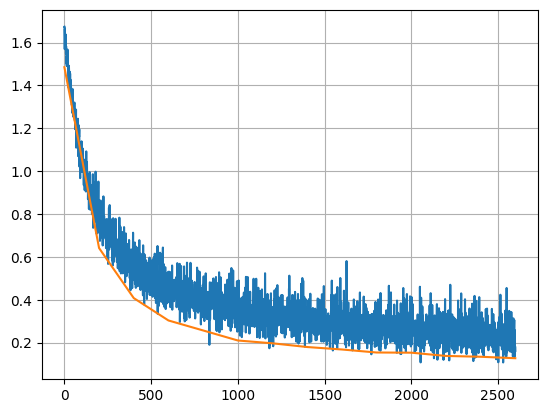

In [31]:
plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val")
plt.grid()
plt.show()

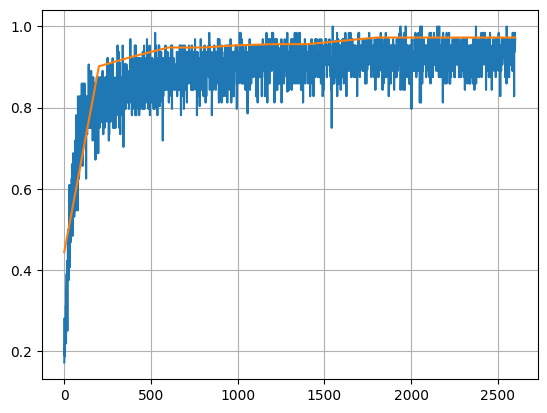

In [32]:
plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["acc"] for i in record["val"]], label="val")
plt.grid()
plt.show()

In [33]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("./checkpoints/SwinTransformer/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, test_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.4540
accuracy: 0.9046
